# Notiz für Henry:
diese Datei ist dafür da das Neuronale Netz zu entwickeln. In einem Notebook kann man schneller Hyperparameter ändern und einfacher weitere kleine Änderungen vornehmen. Wenn das Gröbste steht können wir das Notebook einfach als .py Datei exportieren und sind happy

## Importieren der wichtigsten Pakete

In [153]:
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

In [154]:
# GPU Test
import tensorflow as tf

# Funktioniert momentan bei mir immernoch nicht
#if tf.test.is_gpu_available():
#   print("GPU is available")
#   print("GPU(s) that Tensorflow recognizes:", tf.config.list_physical_devices('GPU'))
#else:
#   print("GPU not available")
# Manuell auf CPU einschränken
tf.config.set_visible_devices([], 'GPU')

## Sinnvolle Funktionen

In [155]:
################################################################################################### 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
###################################################################################################    

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        value = f'{cm[i, j]:.3f}'  # Runde den Wert auf 3 Dezimalstellen
        plt.text(j, i, value,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
################################################################################################### 
import matplotlib.cm as cm
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[n]).reshape((28,28)), cmap=cm.Greys, interpolation='nearest')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[n],obs_errors[n]))
            n += 1
            
################################################################################################### 

In [156]:
def evaluate(X_test, Y_test):
    # Make predictions on test data
    Y_pred = model.predict(X_test)
    # Calculate loss and accuracy
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(f"loss:     {loss:.3}")
    print(f"accuracy: {accuracy:.3}")

    # Compute the classification report
    report = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
    print(report)
    
    # Plot probability of being zero for true !genre! and non-!genre!
    true_genre = np.where(np.argmax(Y_test, axis=1) == 0)[0]
    true_non_genre = np.where(np.argmax(Y_test, axis=1) != 0)[0]
    
    plt.figure()
    plt.hist(Y_pred[true_genre, 0], bins=50, color='red', label='True !genre!', alpha=0.5)
    plt.hist(Y_pred[true_non_genre, 0], bins=50, color='blue', label='True Non-!genre!', alpha=0.5)
    plt.xlabel('Probability of !hier genre einfügen!')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.legend()

    # Compute the confusion matrix
    confusion_mtx = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(confusion_mtx, classes=range(10), normalize='true')  

## Laden der Daten
Am besten wir fügen das Genre in einer separaten Datei dem Datensatz hinzu und machen ab hier nur mit dem fertigen Datensatz weiter

## Convert target

In [157]:
csv_file = "../data/data_selected.csv"

df = pd.read_csv(csv_file)
df.columns

Index(['Unnamed: 0', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Duration_ms', 'Views', 'Likes', 'Comments',
       'Stream', 'Genre'],
      dtype='object')

In [158]:
features_drop = ['Genre', 'Unnamed: 0']
X = df.drop(features_drop, axis=1)
Y = df['Genre']

In [159]:
# One-Hot-Encoding durchführen
Y = pd.get_dummies(Y)

# label um One-Hot-Encoding hinterher wieder zu übersetzen
genre_mapping = Y.columns
label = []
for index, genre in enumerate(genre_mapping):
    label.append(genre)
    print("Genre", index, ":", genre)


Genre 0 : R&B
Genre 1 : alternative rock
Genre 2 : blues
Genre 3 : classic
Genre 4 : country
Genre 5 : electronic
Genre 6 : hip hop
Genre 7 : jazz
Genre 8 : latin
Genre 9 : pop
Genre 10 : reggaeton
Genre 11 : rock
Genre 12 : soul


## Splitten von Training und Test Datensätzen

In [160]:
# Ich möchte gestratified/geshuffelt werden
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train, X_val,  Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

In [161]:
#from sklearn.model_selection import StratifiedShuffleSplit

# Erstellen Sie den StratifiedShuffleSplit-Teiler
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Verwenden Sie den Teiler, um Ihre Daten in Trainings- und Testsets aufzuteilen.
#for train_index, test_index in sss.split(X, Y):
#    X_train, X_test = X[train_index], X[test_index]
#    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Erstellen Sie einen zweiten StratifiedShuffleSplit-Teiler für das Validierungsset
#    sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
    
#    for train_index, val_index in sss_val.split(X_train, Y_train):
#        X_train, X_val = X_train[train_index], X_train[val_index]
#        Y_train, Y_val = Y_train[train_index], Y_train[val_index]


## Daten skalieren

In [162]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Gewichte berechnen um Überrepräsentation zu vermeiden

In [163]:
from sklearn.utils.class_weight import compute_class_weight

num_classes = len(Y.value_counts())
class_counts = np.sum(Y_train, axis=0)
total_samples = np.sum(class_counts)
class_weights = total_samples / (num_classes * class_counts)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Anpassung der Gewichte auf das One-Hot-kodierte Y_train
Y_train_encoded = np.argmax(Y_train, axis=1)
sample_weights = np.array([class_weights_dict[class_label] for class_label in Y_train_encoded])

# Transformieren, damit die wichtigsten Klassen nicht unterrepräsentiert sind 
# TODO: finde eine gute Funktion dafür
transformed_weights = np.log(sample_weights + 1) #log acc~25% -> funktioniert glaube ich am besten
#transformed_weights = sample_weights ** 2 # square acc~10% -> der ist ziemlich kacke
#transformed_weights = np.exp(sample_weights) # exp acc~7%
#transformed_weights = 1 / (1 + np.exp(-sample_weights)) #sigmoid acc~40%


## Modell
hier ein schönes Modell ergänzen

In [164]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], jit_compile=False)


In [165]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 64)                1024      
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 128)               8320      
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 256)               33024     
                                                                 
 dropout_30 (Dropout)        (None, 256)               0         
                                                                 
 dense_38 (Dense)            (None, 512)              

## Training

In [167]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

batch_size = 32
nb_epoch = 200

# Definiere die Early Stopping-Bedingungen
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

# Definiere die Reduzierung der Lernrate, falls die Verbesserung stagniert
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min', min_lr=1e-7)

hist = model.fit(X_train, Y_train, sample_weight=transformed_weights, validation_data=(X_val, Y_val), 
                 epochs=nb_epoch, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])


Epoch 1/200
130/130 [==============================] - 1s 11ms/step - loss: 1.0878 - accuracy: 0.3293 - val_loss: 1.8575 - val_accuracy: 0.3402 - lr: 1.0000e-04
Epoch 2/200
130/130 [==============================] - 1s 9ms/step - loss: 1.0911 - accuracy: 0.3243 - val_loss: 1.8546 - val_accuracy: 0.3419 - lr: 1.0000e-04
Epoch 3/200
130/130 [==============================] - 1s 9ms/step - loss: 1.1054 - accuracy: 0.3168 - val_loss: 1.8535 - val_accuracy: 0.3419 - lr: 1.0000e-04
Epoch 4/200
130/130 [==============================] - 1s 8ms/step - loss: 1.0966 - accuracy: 0.3202 - val_loss: 1.8560 - val_accuracy: 0.3408 - lr: 1.0000e-04
Epoch 5/200
130/130 [==============================] - 1s 9ms/step - loss: 1.0927 - accuracy: 0.3250 - val_loss: 1.8526 - val_accuracy: 0.3374 - lr: 1.0000e-04
Epoch 6/200
130/130 [==============================] - 1s 10ms/step - loss: 1.0948 - accuracy: 0.3272 - val_loss: 1.8580 - val_accuracy: 0.3408 - lr: 1.0000e-04
Epoch 7/200
130/130 [=================

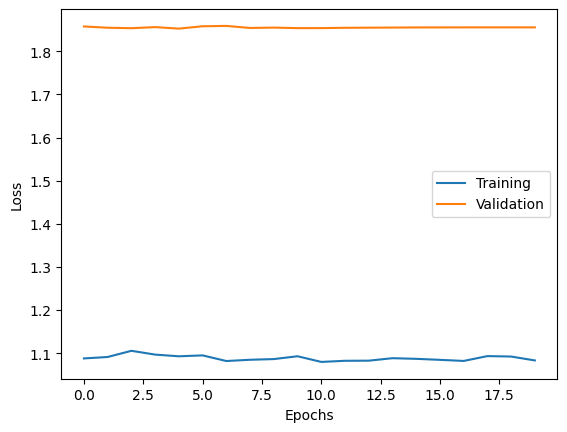

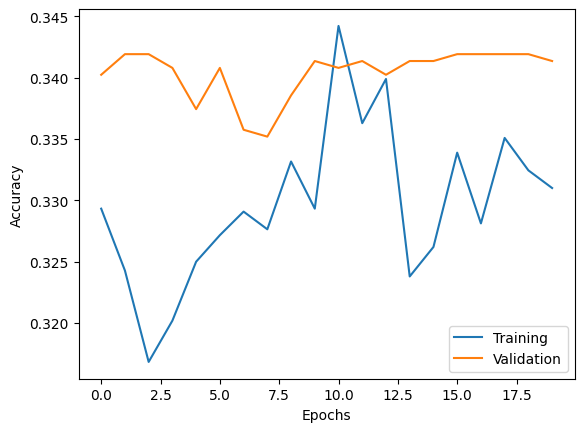

In [168]:
plot_history(hist)

## Vorhersage

In [169]:
Y_pred = model.predict(X_test)

80/80 [==============================] - 1s 4ms/step


## Evaluation

In [170]:
# Überprüfung auf Spalte mit nur False-Werten
column_with_only_false = Y_val.columns[(Y_val == False).all()]

# Ausgabe der Spalten mit nur False-Werten
if not column_with_only_false.empty:
    print("Spalte mit nur False-Werten gefunden:", column_with_only_false)
else:
    print("Keine Spalte mit nur False-Werten gefunden.")

Keine Spalte mit nur False-Werten gefunden.


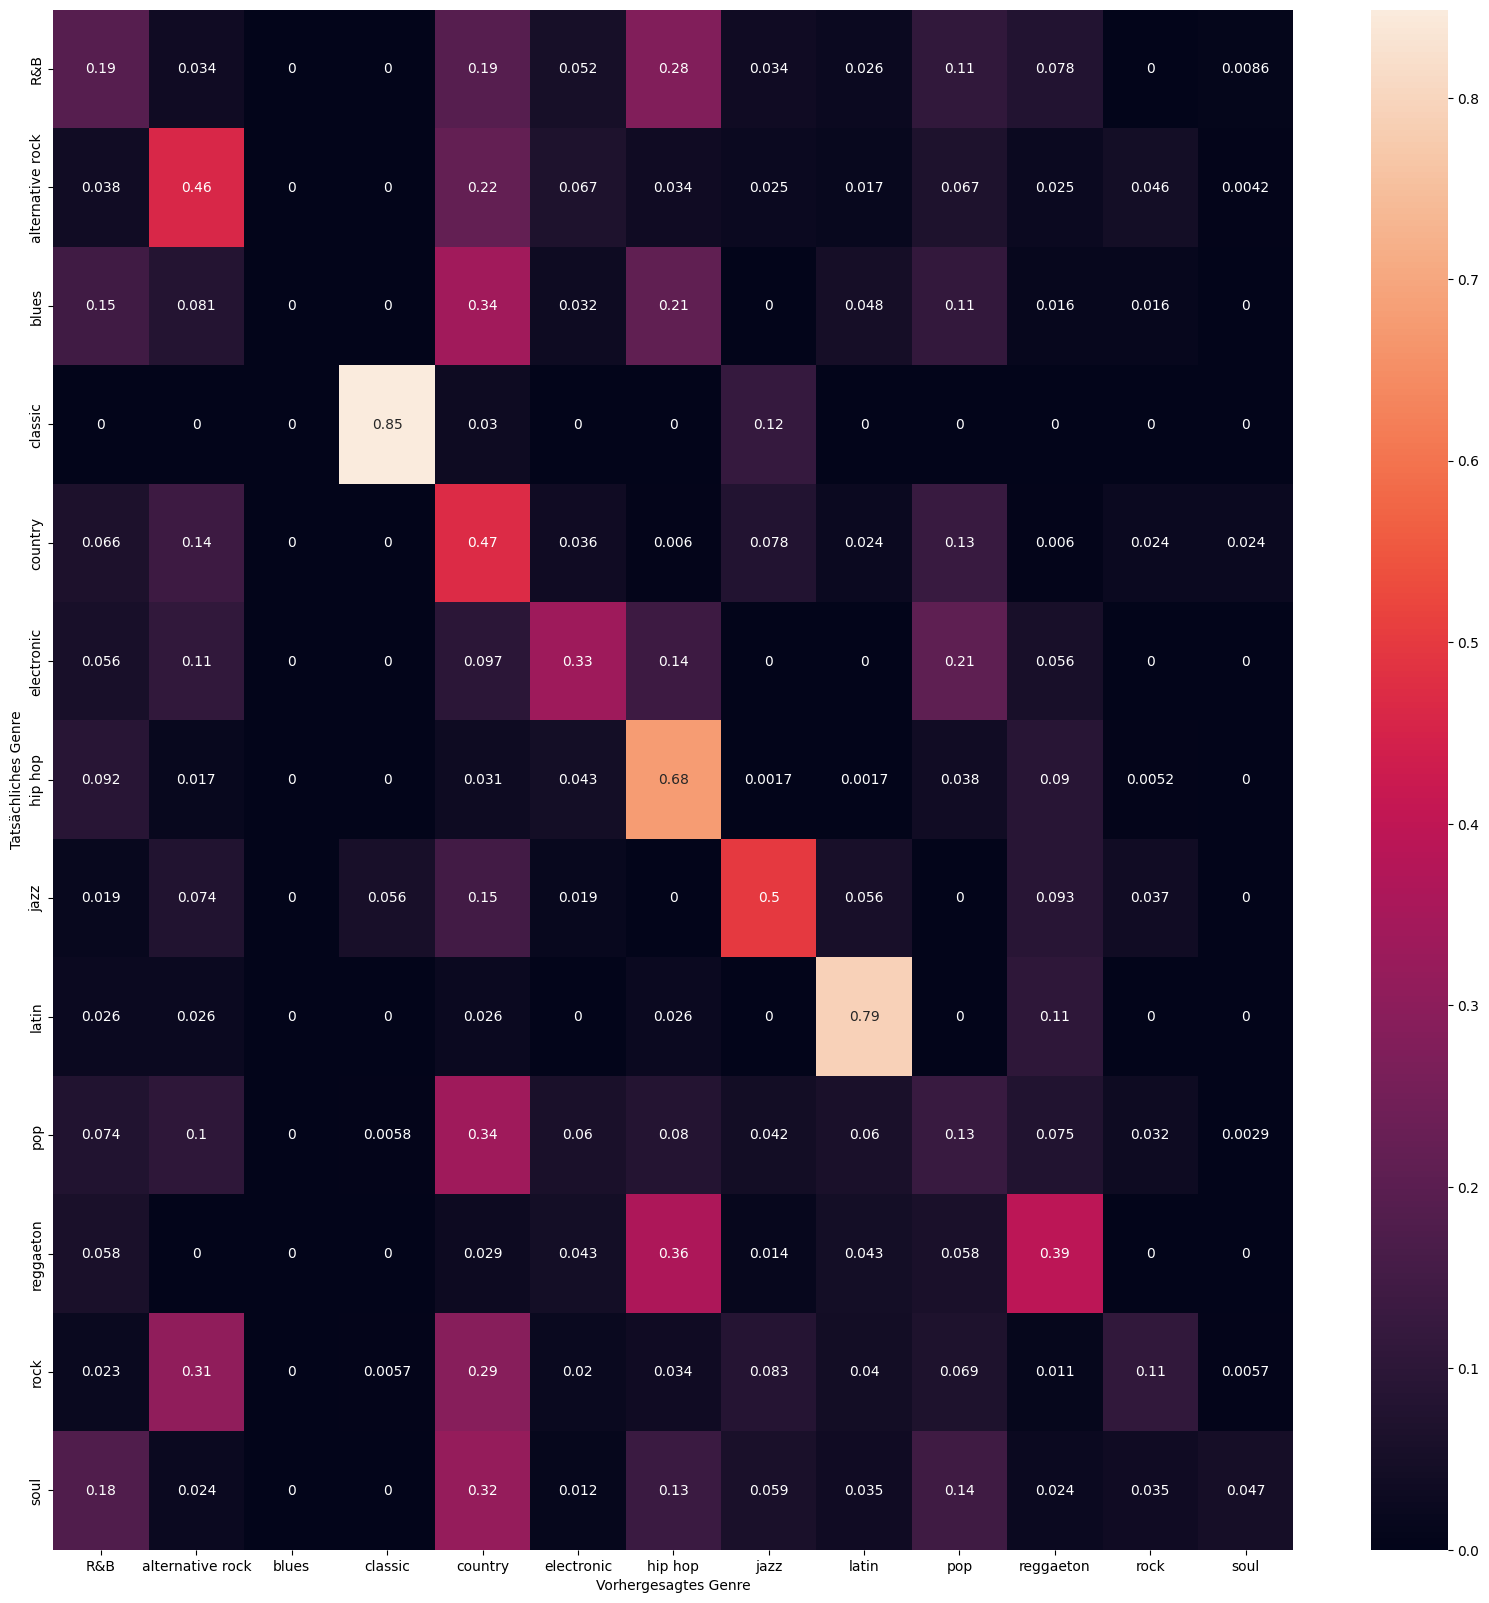

In [171]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_test_classes, Y_pred_classes, normalize='true')
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label)
plt.xlabel('Vorhergesagtes Genre')
plt.ylabel('Tatsächliches Genre')
plt.savefig('../figures/confusion_matrix.png')
plt.show()


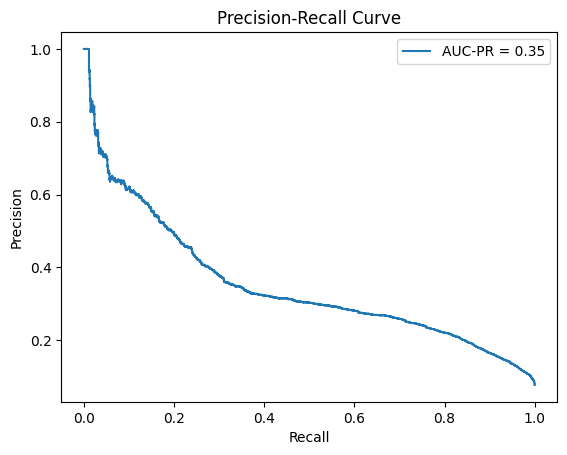

In [174]:
# Precision-Recall Curve
#-> die sollte eigentlich anders aussehen...

from sklearn.metrics import precision_recall_curve, auc

Y_prob = Y_pred

if isinstance(Y_test, pd.DataFrame):
    Y_test = Y_test.values
if isinstance(Y_prob, pd.DataFrame):
    Y_prob = Y_prob.values

precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_prob.ravel())


# Berechne Precision, Recall und Schwellenwerte
precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_prob.ravel())

# Berechne den AUC-PR
auc_pr = auc(recall, precision)

plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()


## Hyperparameter Optimierung 
scheint noch nicht richtig zu laufen

In [ ]:
Y_train = Y_train.values
Y_test  = Y_test.values
print(type(Y_train))
print(Y_train.shape)
print(type(Y_test))
print(Y_test.shape)

In [ ]:
unique_labels_train = np.unique(Y_train)
unique_labels_test = np.unique(Y_test)

print("Einzigartige Labels in Trainingsdaten:", unique_labels_train)
print("Einzigartige Labels in Testdaten:", unique_labels_test)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import f1_score


# Definiere die Funktion zur Erstellung des Modells
def create_model(hidden_units=64, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(units=hidden_units, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=hidden_units*2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=hidden_units*4, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=num_classes, activation='sigmoid'))  # Anpassung: 'softmax' zu 'sigmoid'
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Anpassung: 'categorical_crossentropy' zu 'binary_crossentropy'
    return model


# Definiere den Parameterraum für die Grid Search
param_grid = {
    'hidden_units': [64, 128], #[64, 128, 256],
    'dropout_rate': [0.2] #[0.2, 0.5, 0.8]
}

# Definiere den Scorer für die Grid Search
scorer = make_scorer(f1_score)

# Erstelle das GridSearchCV-Objekt
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5)

# Führe die Grid Search durch
grid_search.fit(X_train, Y_train)


In [ ]:
# Zugriff auf die besten Parameter und den besten Score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Beste Parameter: ", best_params)
print("Best Score: ", best_score)
